# Circular heat plate

In [15]:
using MMJMesh
using MMJMesh.Meshes
using MMJMesh.Plots
using LinearAlgebra
using SparseArrays

include("fem.jl")
include("heat.jl")

import CairoMakie as cm
cm.update_theme!(colormap=:acton)

## Parameters

In [16]:
p = (
    r = 2.2,
    λ = 1.05,
    w = 7.9
)

(r = 2.2, λ = 1.05, w = 7.9)

## Mesh

MakieCore.Plot{MMJMesh.Plots.mplot, Tuple{Mesh{2, 2, MMJMesh.Geometries.GeometricObjectI, MMJMesh.Geometries.GeometricObjectI}}}


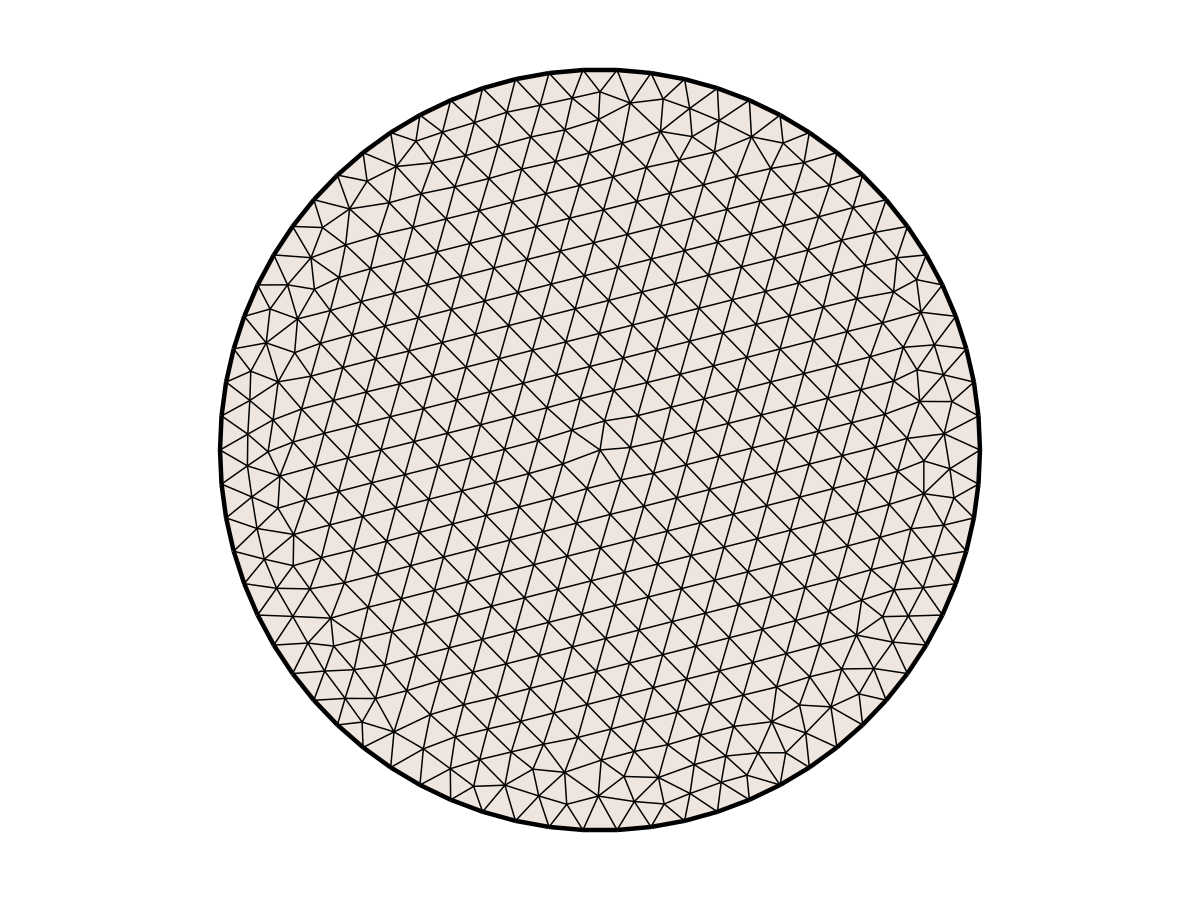

In [17]:
m = Mesh("gmsh/heat-plate.msh")
mplot(m, edgesvisible=true) |> mconf()

## Solution

### Define problem

In [18]:
setdata!(group(m, :elements), :ke_func, heat_ke(p.λ))
setdata!(group(m, :elements), :re_func, heat_re(p.w))

(::var"#refunc#18"{Float64}) (generic function with 1 method)

### Set up linear system

In [19]:
K, r = assemble_kr(m)
apply_dirichlet_bcs!(m.groups[:boundarynodes], K, r);

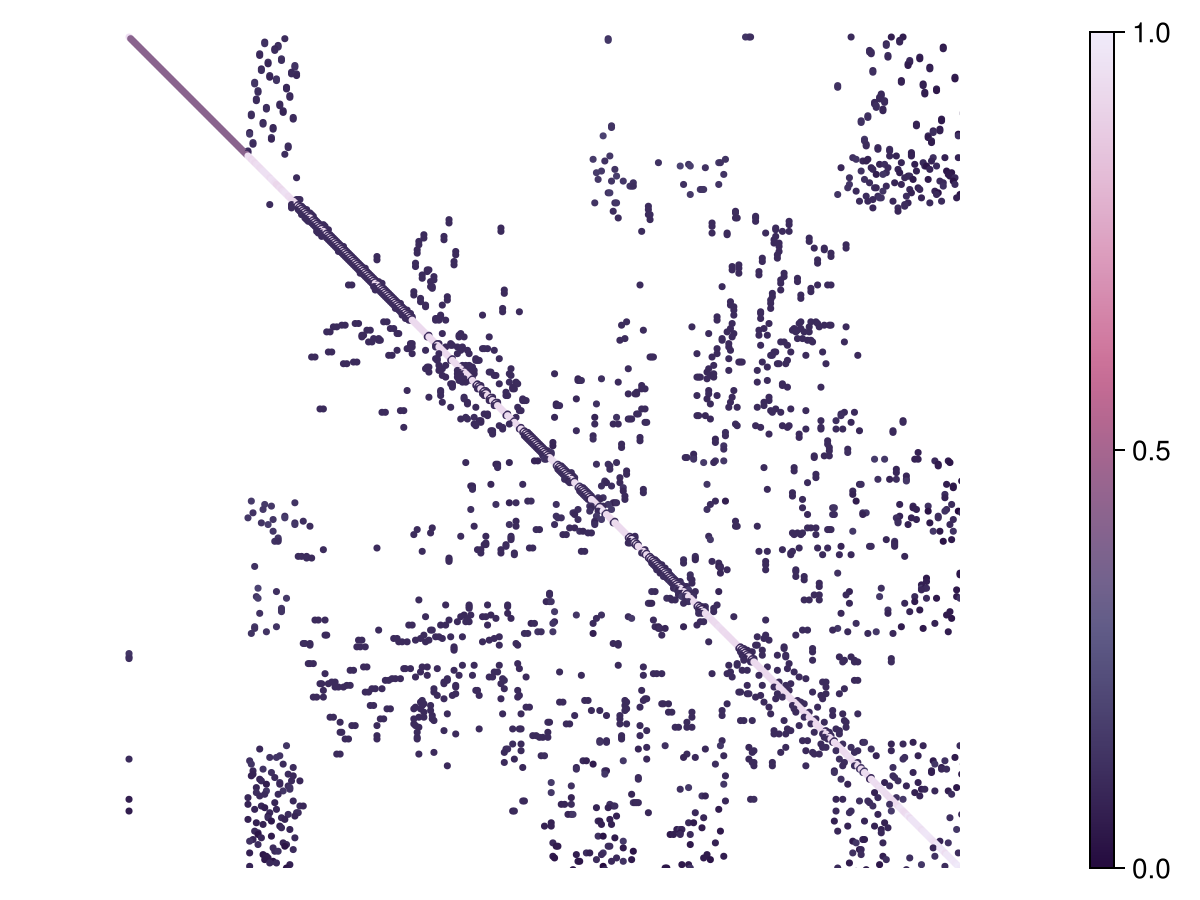

In [20]:
sp = cm.spy(sparse(K), markersize=6, marker=:circle) 
sp.axis.aspect = cm.DataAspect()
cm.hidedecorations!(sp.axis)
cm.hidespines!(sp.axis)
cm.Colorbar(sp.figure[1, 2])
sp.axis.yreversed = true
sp

### Solve

Linear system

In [21]:
KSparse = sparse(K)

@time θHat =  K \ r;
@time θHat =  KSparse \ r;

  0.005837 seconds (4 allocations: 1.908 MiB)
  0.825258 seconds (2.12 M allocations: 145.747 MiB, 3.59% gc time, 99.90% compilation time)


Comparison to exact solution

In [22]:
thetaMax = p.w * p.r^2 / (4 * p.λ)
thetaMaxH = maximum(θHat)

println("         Exact solution: thethaMax = ", thetaMax)
println("Finite element solution: thethaMax = ", thetaMaxH)

         Exact solution: thethaMax = 9.103809523809524
Finite element solution: thethaMax = 9.104435609167364


### Plot

MakieCore.Plot{MMJMesh.Plots.mplot, Tuple{Mesh{2, 2, MMJMesh.Geometries.GeometricObjectI, MMJMesh.Geometries.GeometricObjectI}, Vector{Float64}}}


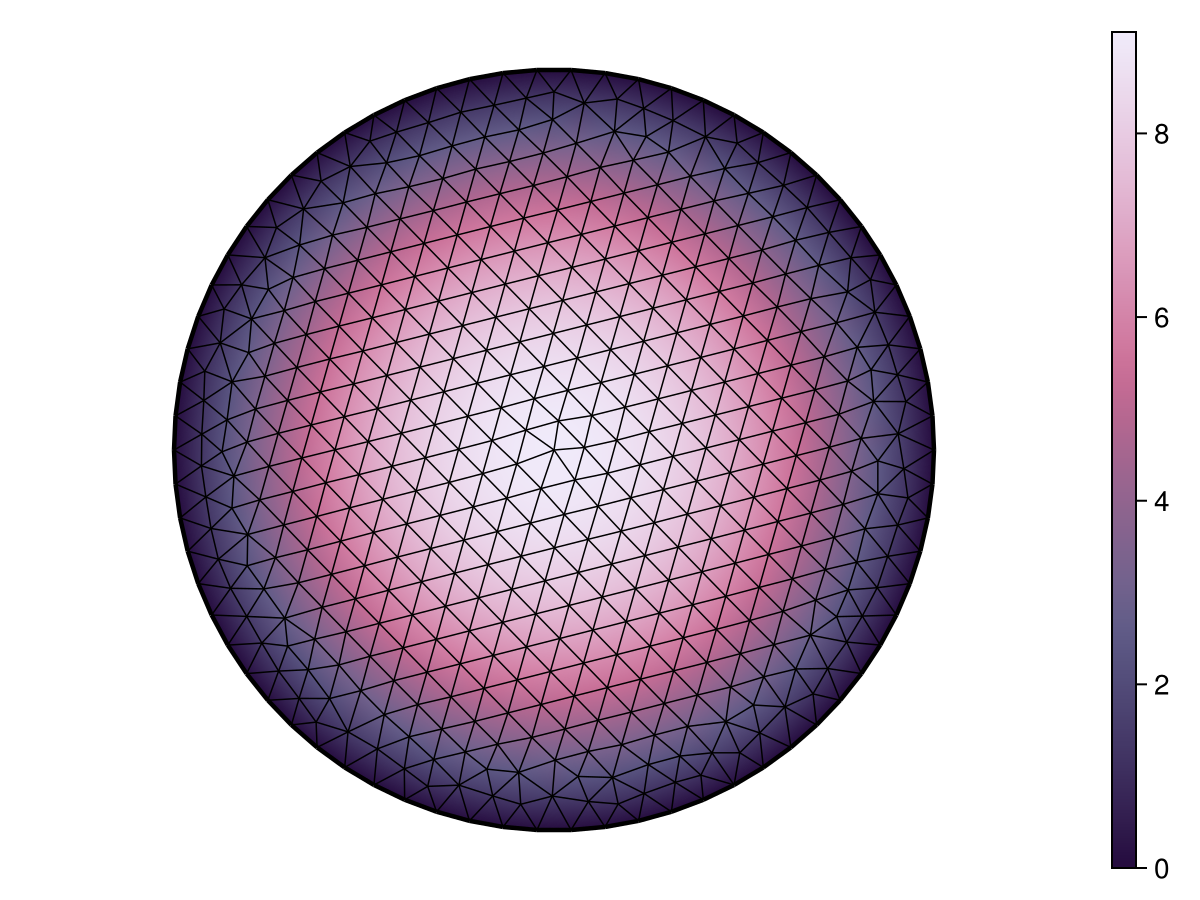

In [23]:
mplot(m, θHat, edgesvisible=true, edgecolor=:black) |> mconf()

Maximum error: 0.007533685568372084
MakieCore.Plot{MMJMesh.Plots.mplot, Tuple{Mesh{2, 2, MMJMesh.Geometries.GeometricObjectI, MMJMesh.Geometries.GeometricObjectI}, Vector{Float64}}}


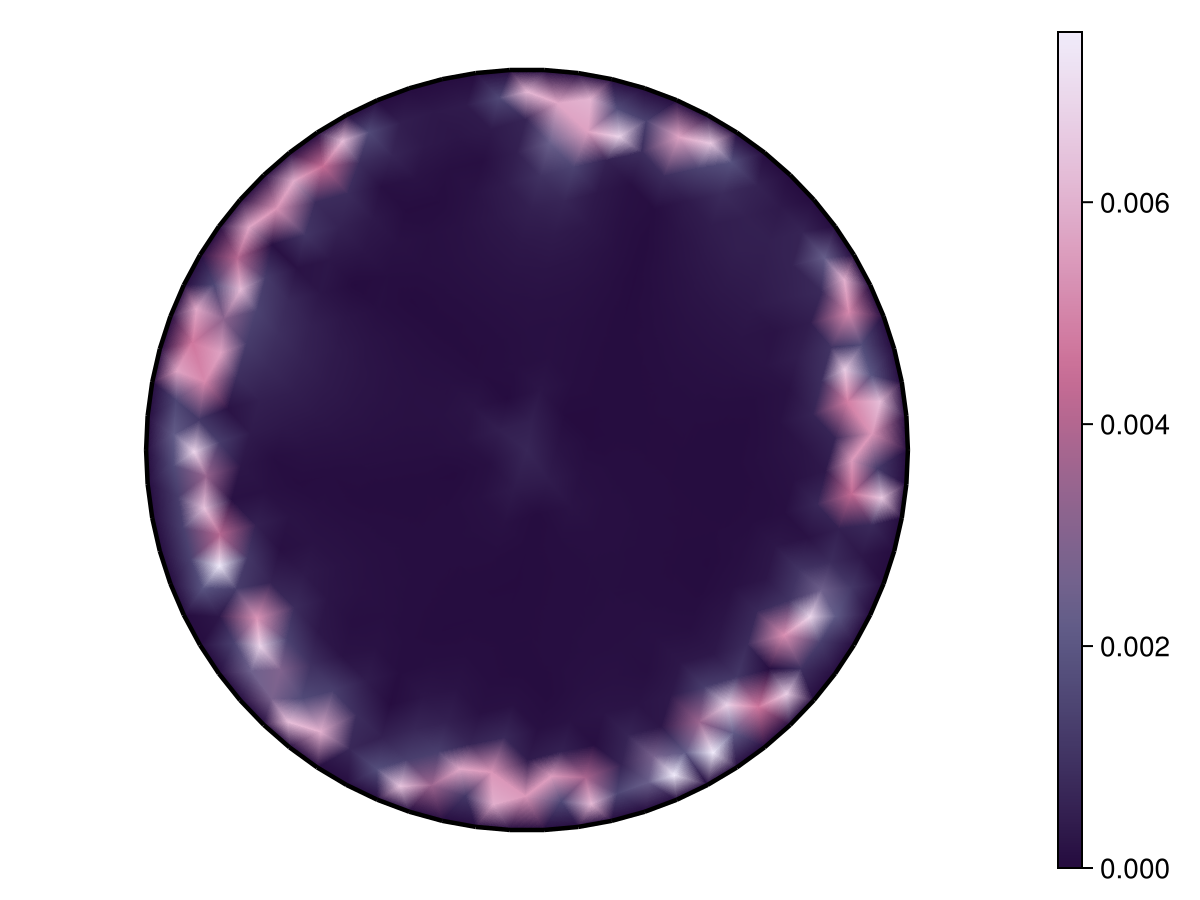

In [24]:
θ = p.w / (4 * p.λ) * (p.r^2 .- [norm(coordinates(m, i))^2 for i ∈ 1:nnodes(m)]) 
e = abs.(θHat - θ)
println("Maximum error: ", maximum(e))
mplot(m, e) |> mconf()